# Classification of Financial Transactions in Python   
In this project I will take a pre labelled dataset of financial transaction.   
I will do the following processes:
- Step 1: Data Quality
    - Check data types and nulls
    - Convert dates and times into datetime columns
    - Check for duplicates
        - Both row duplicates
        - As well as Txn ID duplicates
    - Check the standardisation of the **Classification Tags**
- Step 2: Exploratory Data Analysis (EDA)
- Step 3: Classification
    - Regex Classification
    - Machine Learning Classification
    - Stacked Regex + Machine Learning Classification    

I will then summarize with pros and cons for my approaches as well as suggesting further modifications.



## Step 0: Importing Data   
I will import the data from a csv

In [1]:
# import libraries
import pandas as pd
import numpy as np

In [2]:
# fetch sample data from local csv
df = pd.read_csv('sample_transactions_DS.csv')

# Display basic info about the dataset
print("\n--- Dataset Overview ---")
print(df.info())


--- Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050 entries, 0 to 3049
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction_ID      3050 non-null   object 
 1   Customer_ID         3050 non-null   object 
 2   Transaction_Date    3050 non-null   object 
 3   Description         3050 non-null   object 
 4   Amount              3050 non-null   float64
 5   Classification_Tag  3050 non-null   object 
 6   Transaction_Time    3050 non-null   object 
 7   Status              3050 non-null   object 
dtypes: float64(1), object(7)
memory usage: 190.8+ KB
None


In [3]:
df.head()

,Transaction_ID,Customer_ID,Transaction_Date,Description,Amount,Classification_Tag,Transaction_Time,Status
0,TXN795097,CUST0136,17/02/2024,E-wallet top-up,2921.24,Pre-Funding,05:04:04,Completed
1,TXN825582,CUST0133,29/02/2024,Money transfer via mobile,601.64,Transfers,20:28:17,Refunded
2,TXN654812,CUST0040,24/01/2024,POS cash withdrawal,136.21,Withdrawals,01:04:19,Completed
3,TXN283765,CUST0003,24/01/2024,Online purchase - electronics,3362.72,Card_Payments,06:54:40,Completed
4,TXN749095,CUST0037,28/02/2024,Bank transfer to savings,1304.69,Transfers,08:46:14,Completed


In [4]:
# Convert date and time columns to datetime
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], format='%d/%m/%Y', errors='coerce')
df['Transaction_Time'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S', errors='coerce').dt.time

### DF Summary
The DF has **3050** rows of data with no nulls on any data points.   
I have converted the txn date and txn time columns to datetime.

## Step 1: Data Quality

### Step 1.1 Duplicates

In [5]:
# Check for duplicate rows
print("\n--- Duplicate Rows ---")
duplicates = df.duplicated()
print(f"Total Duplicates: {duplicates.sum()}")


--- Duplicate Rows ---
Total Duplicates: 0


In [6]:
# Count the number of duplicate txn IDs
num_duplicate_txn_ids = df.duplicated(subset=['Transaction_ID']).sum()
print(f"\nTotal Duplicate Transaction_IDs: {num_duplicate_txn_ids}")



Total Duplicate Transaction_IDs: 3


In [7]:
# list the duplicate txn IDs
duplicate_txn_ids = df[df.duplicated(subset=['Transaction_ID'], keep=False)].sort_values(by='Transaction_ID')

print("\n--- Duplicate Transaction_IDs Ordered by Transaction_ID ---")
print(duplicate_txn_ids)



--- Duplicate Transaction_IDs Ordered by Transaction_ID ---
     Transaction_ID Customer_ID Transaction_Date  \
681       TXN140180    CUST0153       2024-01-04   
1478      TXN140180    CUST0185       2024-02-07   
645       TXN347489    CUST0037       2024-02-04   
2011      TXN347489    CUST0034       2024-01-05   
1180      TXN950289    CUST0151       2024-02-12   
1580      TXN950289    CUST0075       2024-02-22   

                                            Description   Amount  \
681                         Account pre-funding deposit    38.28   
1478  Auto-generated Card Payments transaction - TX ...  8283.02   
645                             Restaurant bill payment  2093.88   
2011  Auto-generated Transfers transaction - TX Ref ...  4801.13   
1180  Auto-generated Withdrawals transaction - TX Re...  3951.76   
1580  Auto-generated Bill Payments transaction - TX ...  4055.13   

     Classification_Tag Transaction_Time     Status  
681         Pre-Funding         22:52:45  C

In [42]:
# Group by Txn IDs and inspect differences
print("\n--- Summary of Duplicate Transaction_IDs ---")
duplicates_summary = duplicate_txn_ids.groupby("Transaction_ID").agg({
    "Customer_ID": lambda x: list(x), 
    "Transaction_Date": lambda x: list(x), 
    "Amount": lambda x: list(x), 
    "Status": lambda x: list(x),
    "Classification_Tag": lambda x: list(x)
})

print(duplicates_summary)


--- Summary of Duplicate Transaction_IDs ---
                         Customer_ID  \
Transaction_ID                         
TXN140180       [CUST0153, CUST0185]   
TXN347489       [CUST0037, CUST0034]   
TXN950289       [CUST0151, CUST0075]   

                                          Transaction_Date  \
Transaction_ID                                               
TXN140180       [2024-01-04 00:00:00, 2024-02-07 00:00:00]   
TXN347489       [2024-02-04 00:00:00, 2024-01-05 00:00:00]   
TXN950289       [2024-02-12 00:00:00, 2024-02-22 00:00:00]   

                            Amount                  Status  \
Transaction_ID                                               
TXN140180         [38.28, 8283.02]  [Completed, Completed]   
TXN347489       [2093.88, 4801.13]   [Refunded, Completed]   
TXN950289       [3951.76, 4055.13]  [Completed, Completed]   

                          Classification_Tag  
Transaction_ID                                
TXN140180       [Pre-Funding, Card Pa

### Duplicates Summary   
There are no row duplicates but there are duplicates Txn IDs that have different customer IDs.    
This might be an error in data entry, a fraud case or any other type of anomaly.    
We have grouped the txns here below to get a better readable summary.     
The amounts for the txn IDs are also different and in some cases the status and classification tag as well.     
This might be fraud and/or problems with data entry/merging.     
The best way forward is to highlight this and get clarification before adding the data to the model to avoid misdirecting the model.      
For our case, we will keep the duplicates since we need the training data but in a real case, we would need to verify before including.

The pros for removing this data are:
- Prevents introducing wrong labels into the model.
- Ensures only clean and reliable data is used for classification.

The cons are:
- The model loses exposure to transactions that might be legitimately tagged under multiple categories.
- Requires a separate process for handling flagged transactions.

We will review the model accuracy and revisit our decision

### Step 1.2 Classification Tags

In [9]:
# Get unique Classification_Tag values
unique_tags = df['Classification_Tag'].unique()

# Display all unique values
print("Unique Classification Tags:")
for tag in sorted(unique_tags):
    print(tag)


Unique Classification Tags:
Bank Charges
Bill Payments
Bill-Payments
BillPayments
Bill_Payments
Card Payments
CardPayments
Card_Payments
Pre Funding
Pre-Funding
Pre-funding
Prefunding
Transfers
Withdrawals
Withdrawals - 
Withdrawals.  


In [10]:
# Define a mapping dictionary for cleaning Classification_Tag
classification_mapping = {
    'Bank Charges': 'Bank Charges',
    
    'Bill Payments': 'Bill Payments',
    'Bill-Payments': 'Bill Payments',
    'BillPayments': 'Bill Payments',
    'Bill_Payments': 'Bill Payments',
    
    'Card Payments': 'Card Payments',
    'CardPayments': 'Card Payments',
    'Card_Payments': 'Card Payments',
    
    'Pre Funding': 'Pre-Funding',
    'Pre-Funding': 'Pre-Funding',
    'Pre-funding': 'Pre-Funding',
    'Prefunding': 'Pre-Funding',
    
    'Transfers': 'Transfers',
    
    'Withdrawals': 'Withdrawals',
    'Withdrawals - ': 'Withdrawals',
    'Withdrawals.': 'Withdrawals',
    'Withdrawals.  ': 'Withdrawals'
}

# Apply the mapping
df['Classification_Tag'] = df['Classification_Tag'].replace(classification_mapping)


In [11]:
print("Updated Unique Classification Tags:")
print(df['Classification_Tag'].unique())

Updated Unique Classification Tags:
['Pre-Funding' 'Transfers' 'Withdrawals' 'Card Payments' 'Bill Payments'
 'Bank Charges']


### Classification Tags Summary   
The classification tag naming was not standardized with tags such as Pre-Funding showing up in different versions.     
This would have been picked up by the model as different tags thus introducing a bad bias to the classification logic.   
In this case I reveiewed the tags manually as it is a small dataset.   
For bigger datasets, automated means such as simple fuzzy matching might work but with various error margins.

## Step 2: EDA

In [12]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Count total transactions and unique descriptions per classification tag
tag_counts = df.groupby("Classification_Tag")["Description"].agg(
    Transactions="count", Unique_Descriptions="nunique"
).reset_index()

# Sort by transaction count for better visibility
tag_counts = tag_counts.sort_values(by="Transactions", ascending=False)

# Display results
print(tag_counts)

  Classification_Tag  Transactions  Unique_Descriptions
5        Withdrawals           622                  400
1      Bill Payments           614                  421
2      Card Payments           601                  410
4          Transfers           587                  388
3        Pre-Funding           576                  387
0       Bank Charges            50                   50


<Figure size 720x432 with 0 Axes>

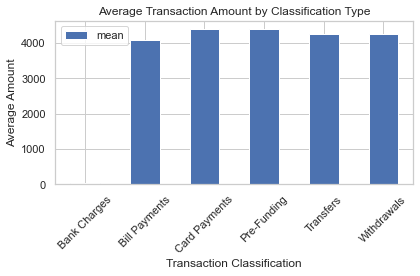

In [43]:
# Plotting the distribution of transaction amounts
plt.figure(figsize=(10, 6))
df.groupby('Classification_Tag')['Amount'].describe().plot(kind='bar', y='mean')
plt.title('Average Transaction Amount by Classification Type')
plt.ylabel('Average Amount')
plt.xlabel('Transaction Classification')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

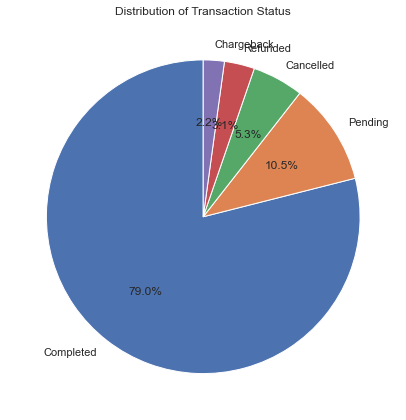

In [47]:
# Status distribution
plt.figure(figsize=(10, 6))
df['Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Transaction Status')
plt.ylabel('')
plt.tight_layout()
plt.show()

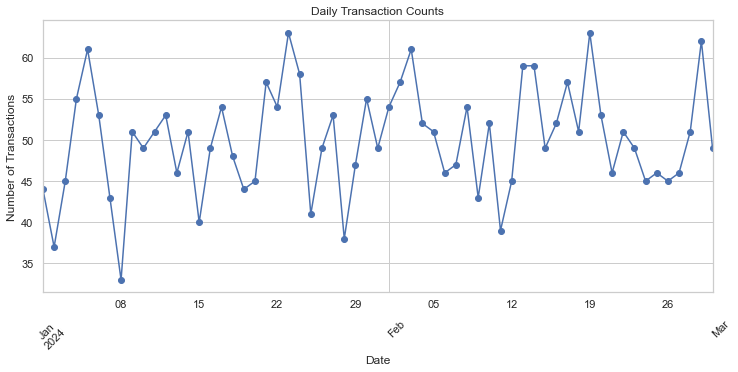

In [15]:
# Set plot style
sns.set_theme(style="whitegrid")

# 1. Transaction Trends Over Time
df["Transaction_Date"] = pd.to_datetime(df["Transaction_Date"])
daily_counts = df.groupby("Transaction_Date").size()

plt.figure(figsize=(12, 5))
daily_counts.plot(kind="line", marker="o", title="Daily Transaction Counts")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()

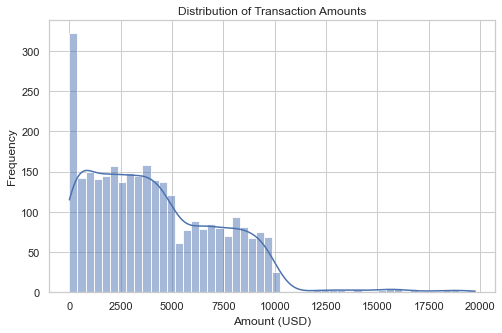

In [16]:
# 2. Transaction Amount Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Amount"], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount (USD)")
plt.ylabel("Frequency")
plt.show()

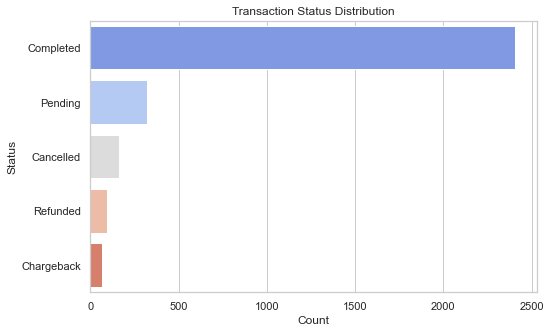

In [17]:
# 3. Transaction Status Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, y="Status", order=df["Status"].value_counts().index, palette="coolwarm")
plt.title("Transaction Status Distribution")
plt.xlabel("Count")
plt.ylabel("Status")
plt.show()

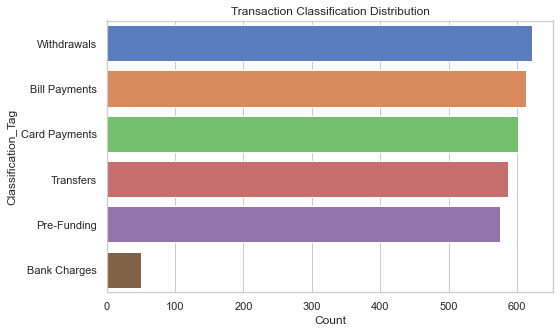

In [18]:
# 4. Classification Tag Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, y="Classification_Tag", order=df["Classification_Tag"].value_counts().index, palette="muted")
plt.title("Transaction Classification Distribution")
plt.xlabel("Count")
plt.ylabel("Classification_Tag")
plt.show()


In [19]:
# 5. Identifying Potential Anomalies
# Check for unusually high transaction amounts
high_value_threshold = df["Amount"].quantile(0.99)
outliers = df[df["Amount"] > high_value_threshold]

print("\n--- High-Value Transactions (Top 1% Amounts) ---")
print(outliers[["Transaction_ID", "Amount", "Classification_Tag", "Status"]].sort_values(by="Amount", ascending=False))



--- High-Value Transactions (Top 1% Amounts) ---
    Transaction_ID    Amount Classification_Tag      Status
739      TXN139594  19756.32        Withdrawals   Completed
814      TXN417098  19537.51          Transfers   Completed
661      TXN989558  19507.91        Withdrawals   Cancelled
136      TXN144524  19221.62      Card Payments   Completed
442      TXN224042  19192.17        Withdrawals   Completed
897      TXN816125  18798.16          Transfers   Completed
951      TXN858499  18707.91          Transfers     Pending
187      TXN386942  18579.09          Transfers   Completed
890      TXN808126  18517.37        Pre-Funding   Completed
305      TXN758796  18472.45      Card Payments   Completed
275      TXN407283  18310.03          Transfers     Pending
392      TXN242546  18017.27        Withdrawals   Cancelled
678      TXN854798  17665.54          Transfers   Completed
121      TXN830619  17172.13        Withdrawals   Completed
703      TXN311356  16924.32      Bill Payments   

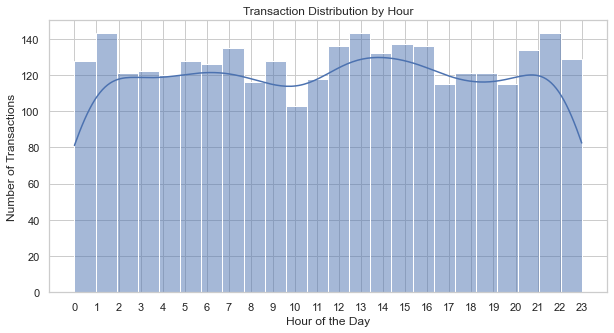

In [20]:
# 6. Time-Based Anomalies (Transactions at Odd Hours)
df["Transaction_Hour"] = pd.to_datetime(df["Transaction_Time"], format="%H:%M:%S").dt.hour

plt.figure(figsize=(10, 5))
sns.histplot(df["Transaction_Hour"], bins=24, kde=True)
plt.title("Transaction Distribution by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.xticks(range(0, 24))
plt.show()

### EDA Summary     
The data we have is not large enough to be training data for an accurate model but will be enough to run a test.   


## Step 3: Classification   
We will now proceed to classify the transactions into various classes/tags.   
In this section, we will try out various approaches, assessing the accuracy and efficiency of each approach.   
The approaches are:   
- A basic regex-esque approach to classifying based on key words on the txn narration/description.
- A machine learning approach to classification using a section of the data to train classification.
- A stacked approach combining regex and machine learning.

### Step 3.1 Regex Approach   
Here I have tried two approaches.    
- General Approach: A very basic and general regex pattern match
- Intensive Matching: Adding more context to the regex patterns to try and get more granular

In [21]:
# import libraries
import re

#### Step 3.1.1 General Regex Approach

In [24]:
# Define regex patterns for classification
classification_patterns = {
    "Bill Payments": r"(?i)\b(bill payments?|electricity|internet|restaurant|subscription)\b",
    "Card Payments": r"(?i)\b(card payments?)\b",
    "Withdrawals": r"(?i)\b(withdrawals?)\b",
    "Transfers": r"(?i)\b(transfers?)\b",
    "Pre-Funding": r"(?i)\b(pre[-\s]?funding)\b",
    "Bank Charges": r"(?i)\b(charges|fees)\b"
}

# Function to classify transactions based on regex
def classify_transaction(description):
    for category, pattern in classification_patterns.items():
        if re.search(pattern, description):
            return category
    return "Unclassified"  # Fallback for unmatched cases

# Apply classification
df["Predicted_Classification"] = df["Description"].apply(classify_transaction)

# Calculate the percentage of correctly classified records
correct_classifications = (df["Classification_Tag"] == df["Predicted_Classification"]).sum()
total_records = len(df)
accuracy_percentage = (correct_classifications / total_records) * 100

# Display the results
print(f"Correctly Classified Records: {correct_classifications}/{total_records}")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")

# Identify misclassified transactions
misclassified = df[df["Classification_Tag"] != df["Predicted_Classification"]]

# Display misclassified transactions
print("\nMisclassified Transactions:")
print(misclassified[["Description", "Classification_Tag", "Predicted_Classification"]].to_string(index=False))



Correctly Classified Records: 2672/3050
Accuracy Percentage: 87.61%

Misclassified Transactions:
                         Description Classification_Tag Predicted_Classification
                     E-wallet top-up        Pre-Funding             Unclassified
       Online purchase - electronics      Card Payments             Unclassified
                      Salary deposit        Pre-Funding             Unclassified
               Water bill settlement      Bill Payments             Unclassified
             Restaurant bill payment      Card Payments            Bill Payments
                     E-wallet top-up        Pre-Funding             Unclassified
       Online purchase - electronics      Card Payments             Unclassified
                     E-wallet top-up        Pre-Funding             Unclassified
               Water bill settlement      Bill Payments             Unclassified
               Water bill settlement      Bill Payments             Unclassified
            

#### Step 3.1.2 Granular Regex Approach

In [25]:

# Define regex patterns for classification
classification_patterns = {
    "Bank Charges": r"(?i)\bbank charges?\b|\bservice fee\b|\bmaintenance fee\b",
    "Bill Payments": r"(?i)\bbill payments?\b|\bsubscription\b|\brenewal\b|\butility\b|\brent\b|\bwater bill\b",
    "Card Payments": r"(?i)\bcard payments?\b|\bcard\b|\btransaction\b|\bpos\b|\bstore\b|\bshopping\b|\bonline purchase\b|\brestaurant bill payment\b|\bgrocery store\b",
    "Pre-Funding": r"(?i)\bpre[-_]?funding\b|\bfund\b|\bdeposit\b|\btop[-_]?up\b|\bsalary\b|\bwallet\b",
    "Transfers": r"(?i)\btransfers?\b|\btransfer\b|\bsent\b|\bto\b|\bfrom\b",
    "Withdrawals": r"(?i)\bwithdrawals?\b|\bwithdraw\b|\bATM\b|\bPOS cash withdrawal\b|\bcash out\b|\bPOS\s+cash\b"
}

# Function to classify transactions based on regex
def classify_transaction(description):
    for category, pattern in classification_patterns.items():
        if re.search(pattern, description):
            return category
    return "Unknown"  # Default category if no match

# Apply classification
df["Predicted_Classification_2"] = df["Description"].astype(str).apply(classify_transaction)

# Compare predicted classification with actual classification
df["Correct"] = df["Classification_Tag"] == df["Predicted_Classification_2"]

# Calculate accuracy
accuracy = df["Correct"].mean() * 100
print(f"Classification Accuracy: {accuracy:.2f}%")

# Show misclassified transactions
misclassified = df[~df["Correct"]][["Description", "Classification_Tag", "Predicted_Classification_2"]]
print("\nMisclassified Transactions:")
print(misclassified.to_string(index=False))

# Show misclassified transactions
misclassified = df[~df["Correct"]][["Description", "Classification_Tag", "Predicted_Classification_2"]]
print("\nMisclassified Transactions:")
print(misclassified.to_string(index=False))

Classification Accuracy: 55.70%

Misclassified Transactions:
                                          Description Classification_Tag Predicted_Classification_2
                                  POS cash withdrawal        Withdrawals              Card Payments
                              Restaurant bill payment      Card Payments              Bill Payments
                              Restaurant bill payment      Card Payments              Bill Payments
                                  POS cash withdrawal        Withdrawals              Card Payments
                              Restaurant bill payment      Card Payments              Bill Payments
                              Restaurant bill payment      Card Payments              Bill Payments
                              Restaurant bill payment      Card Payments              Bill Payments
                                  POS cash withdrawal        Withdrawals              Card Payments
                              Restauran

### Regex Summary    
The general regex performs better that the granular approach.   
this is because some txn narratives are very similar with no clear distinction on why they were classified differently.    
While the general regex outperforms the granular regex in this case, the general regex is not a very recommended approach as it can potentially mismatch txns when faced with a larger dataset.     
The better approach is to get a larger dataset to enhance the granular regex logic and improve the accuracy. The granular regex can perform better.    
There is however a ceiling to the regex performance seeing as some of the txn narratives are very difficult to automatically classify.

### Step 3.2 Machine Learning Approach     

I will try three approaches:    
- Machine Learning Approach    
- Stacked Regex & Machine Learning Approach    

There are various models to consider for this task.    

| **Model**            | **Pros**  | **Cons**  | **Best Use Case** |
|----------------------|-------------|-------------|--------------------|
| **Logistic Regression** | Simple, fast, and interpretable <br> Works well with TF-IDF text features <br> Handles sparse text data well | Assumes linear relationships <br> May struggle with complex patterns | When text features are well-separated and efficiency is needed |
| **Naive Bayes (MultinomialNB)** | Fastest model for text classification <br> Works well with word frequencies <br> Performs well on small datasets | Assumes word independence (not always true) <br> Less flexible for complex interactions | When classification relies on word frequency (e.g., spam detection) |
| **Random Forest** | Captures complex patterns <br> Handles non-linear relationships <br> More robust than Logistic Regression | Slower and more memory-intensive <br> Can overfit if not tuned properly | When there are complex interactions between words |
| **Support Vector Machine (SVM)** | Works well with high-dimensional TF-IDF features <br> Effective when categories are well-separated | Computationally expensive <br> Slower with large datasets | When maximizing decision boundary margins is critical |
| **Neural Networks (Deep Learning)** | Can capture deeper word relationships <br> Best for long, complex descriptions | Requires a large dataset <br> Computationally expensive | When descriptions are longer and require context understanding |

---

#### Why Logistic Regression and Random Forest?

**Logistic Regression**
**Pros:**
- ✅ Best baseline model for text classification
- ✅ Efficient for structured, short transaction descriptions
- ✅ Works well with TF-IDF transformation
- ✅ Interpretable results (each word contributes to classification linearly)

**Cons:**
- ❌ Fails for complex non-linear patterns
- ❌ If transactions have word dependencies, performance may drop

📌 **Why We Picked It?**  
- It’s a **fast, reliable** choice for text classification.  
- It's easy to interpret, debug, and tune.  

---

**Random Forest**
**Pros:**
- ✅ Captures non-linear relationships
- ✅ More flexible than Logistic Regression
- ✅ Less sensitive to overfitting compared to deep learning

**Cons:**
- ❌ Slower than Logistic Regression
- ❌ Not ideal for sparse text data (TF-IDF has many zero features)

📌 **Why We Picked It?**  
- To **capture any non-linear interactions** in transaction descriptions.  
- To **compare performance with Logistic Regression** and see if extra complexity helps.  

#### Step 3.2.1 Logistic Regression

In [26]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [27]:
# Extract features (Description) and labels (Classification_Tag)
X = df["Description"].astype(str)
y = df["Classification_Tag"]

# Encode target labels
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))


Model Accuracy: 1.00

Classification Report:
                precision    recall  f1-score   support

 Bank Charges       1.00      0.82      0.90        11
Bill Payments       1.00      1.00      1.00       114
Card Payments       1.00      1.00      1.00       135
  Pre-Funding       1.00      1.00      1.00       125
    Transfers       0.99      1.00      1.00       105
  Withdrawals       0.99      1.00      1.00       120

     accuracy                           1.00       610
    macro avg       1.00      0.97      0.98       610
 weighted avg       1.00      1.00      1.00       610



In [28]:
# Predict on the entire dataset
df["ML_Predicted_Classification"] = y_encoder.inverse_transform(model.predict(vectorizer.transform(X)))

# Calculate accuracy
correct_predictions = (df["Classification_Tag"] == df["ML_Predicted_Classification"]).sum()
total_records = len(df)
accuracy_percentage = (correct_predictions / total_records) * 100

# Print results
print(f"Correctly Classified Records: {correct_predictions}/{total_records}")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(df["Classification_Tag"], df["ML_Predicted_Classification"]))

df.head()

Correctly Classified Records: 3042/3050
Accuracy Percentage: 99.74%

Classification Report:
               precision    recall  f1-score   support

 Bank Charges       1.00      0.84      0.91        50
Bill Payments       1.00      1.00      1.00       614
Card Payments       1.00      1.00      1.00       601
  Pre-Funding       1.00      1.00      1.00       576
    Transfers       0.99      1.00      1.00       587
  Withdrawals       0.99      1.00      1.00       622

     accuracy                           1.00      3050
    macro avg       1.00      0.97      0.98      3050
 weighted avg       1.00      1.00      1.00      3050



,Transaction_ID,Customer_ID,Transaction_Date,Description,Amount,Classification_Tag,Transaction_Time,Status,Transaction_Hour,Predicted_Classification,Predicted_Classification_2,Correct,ML_Predicted_Classification
0,TXN795097,CUST0136,2024-02-17,E-wallet top-up,2921.24,Pre-Funding,05:04:04,Completed,5,Unclassified,Pre-Funding,True,Pre-Funding
1,TXN825582,CUST0133,2024-02-29,Money transfer via mobile,601.64,Transfers,20:28:17,Refunded,20,Transfers,Transfers,True,Transfers
2,TXN654812,CUST0040,2024-01-24,POS cash withdrawal,136.21,Withdrawals,01:04:19,Completed,1,Withdrawals,Card Payments,False,Withdrawals
3,TXN283765,CUST0003,2024-01-24,Online purchase - electronics,3362.72,Card Payments,06:54:40,Completed,6,Unclassified,Card Payments,True,Card Payments
4,TXN749095,CUST0037,2024-02-28,Bank transfer to savings,1304.69,Transfers,08:46:14,Completed,8,Transfers,Transfers,True,Transfers


#### Logistic Regression Performance Summary     

**Model Accuracy**
- The model achieved an accuracy of 1.00 **(100%)**, meaning it classified almost all transactions correctly.
- This indicates that the model has learned the patterns in the transaction descriptions very well.   
- This high scoring is concerning and can be a fluke.

**Key Observations**
- **Bill Payments, Card Payments, Pre-Funding, Transfers, and Withdrawals** have perfect precision and recall.
- **Bank Charges has a recall of 0.82**, meaning **18% of actual Bank Charges transactions were misclassified into other categories**.
- **Macro Average Recall (0.97) is slightly lower than 1.00**, indicating that some categories (like Bank Charges) had minor misclassifications.

**Conclusion**
- The 100% accuracy on the model is concerning and may indicate **overfitting** or **data leakage**.  
- We need to test on **unseen data** to verify that we don't have overfitting.
- We need to try another model just to confirm.

#### Step 3.2.2 Random Forest 

In [29]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [34]:
X = df["Description"].astype(str)
y = df["Classification_Tag"]

# Encode target labels
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

# Make Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

Random Forest Model Accuracy: 1.00

Classification Report:
                precision    recall  f1-score   support

 Bank Charges       1.00      0.91      0.95        11
Bill Payments       1.00      1.00      1.00       114
Card Payments       1.00      1.00      1.00       135
  Pre-Funding       1.00      1.00      1.00       125
    Transfers       0.99      1.00      1.00       105
  Withdrawals       1.00      1.00      1.00       120

     accuracy                           1.00       610
    macro avg       1.00      0.98      0.99       610
 weighted avg       1.00      1.00      1.00       610



In [35]:
# Predict on the entire dataset
df["RF_Predicted_Classification"] = y_encoder.inverse_transform(model.predict(vectorizer.transform(X)))
# Calculate accuracy
correct_rf_predictions = (df["Classification_Tag"] == df["RF_Predicted_Classification"]).sum()
total_rf_records = len(df)
rf_accuracy_percentage = (correct_rf_predictions / total_rf_records) * 100

# Print results
print(f"Correctly Classified Records: {correct_rf_predictions}/{total_rf_records}")
print(f"Accuracy Percentage: {rf_accuracy_percentage:.2f}%")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(df["Classification_Tag"], df["RF_Predicted_Classification"]))

df.head()


Correctly Classified Records: 3049/3050
Accuracy Percentage: 99.97%

Classification Report:
               precision    recall  f1-score   support

 Bank Charges       1.00      0.98      0.99        50
Bill Payments       1.00      1.00      1.00       614
Card Payments       1.00      1.00      1.00       601
  Pre-Funding       1.00      1.00      1.00       576
    Transfers       1.00      1.00      1.00       587
  Withdrawals       1.00      1.00      1.00       622

     accuracy                           1.00      3050
    macro avg       1.00      1.00      1.00      3050
 weighted avg       1.00      1.00      1.00      3050



,Transaction_ID,Customer_ID,Transaction_Date,Description,Amount,Classification_Tag,Transaction_Time,Status,Transaction_Hour,Predicted_Classification,Predicted_Classification_2,Correct,ML_Predicted_Classification,RF_Predicted_Classification
0,TXN795097,CUST0136,2024-02-17,E-wallet top-up,2921.24,Pre-Funding,05:04:04,Completed,5,Unclassified,Pre-Funding,True,Pre-Funding,Pre-Funding
1,TXN825582,CUST0133,2024-02-29,Money transfer via mobile,601.64,Transfers,20:28:17,Refunded,20,Transfers,Transfers,True,Transfers,Transfers
2,TXN654812,CUST0040,2024-01-24,POS cash withdrawal,136.21,Withdrawals,01:04:19,Completed,1,Withdrawals,Card Payments,False,Withdrawals,Withdrawals
3,TXN283765,CUST0003,2024-01-24,Online purchase - electronics,3362.72,Card Payments,06:54:40,Completed,6,Unclassified,Card Payments,True,Card Payments,Card Payments
4,TXN749095,CUST0037,2024-02-28,Bank transfer to savings,1304.69,Transfers,08:46:14,Completed,8,Transfers,Transfers,True,Transfers,Transfers


#### Random Forest Performance Summary      

- The **Random Forest** model achieved an accuracy of 1.00 **(100%)**, meaning it classified almost all transactions correctly.
- This suggests that the model has learned the transaction patterns very effectively, but we also need to check if it’s truly generalizing. This might also be a fluke.

**Key Observations**
- **Bank Charges recall is 0.91**, meaning **9% of actual Bank Charges transactions were misclassified into other categories**.
- **All other categories have perfect precision and recall**, indicating strong performance.
- **Macro Average Recall (0.98) is slightly lower than 1.00**, due to the **Bank Charges misclassification**.

**Is This 100% Accuracy a Fluke?**
A **perfect model score is rare** and might indicate **overfitting** or **data leakage**.

**How to Validate If the Model Is Truly Generalizing**
**1. Test on Completely Unseen Data**
**2. Use Cross-Validation**
**3. Check Misclassified Transactions**
**4. Compare with Logistic Regression**

**Conclusion**
- **Random Forest** improved recall for Bank Charges **(0.91 vs. 0.82** in Logistic Regression), making it slightly better at handling that category.
- However, **100% accuracy suggests we should test on completely unseen data to confirm reliability.**
- **Cross-validation is recommended** to check if performance is consistent across different test splits.


#### Step 3.2.3 Regex + Random Forest

In [36]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [41]:
classification_patterns = {
    "Bill Payments": r"(?i)\b(bill payments?|electricity|internet|restaurant|subscription)\b",
    "Card Payments": r"(?i)\b(card payments?)\b",
    "Withdrawals": r"(?i)\b(withdrawals?)\b",
    "Transfers": r"(?i)\b(transfers?)\b",
    "Pre-Funding": r"(?i)\b(pre[-\s]?funding)\b",
    "Bank Charges": r"(?i)\b(charges|fees)\b"
}

def classify_with_regex(description):
    for category, pattern in classification_patterns.items():
        if re.search(pattern, description):
            return category
    return "Unclassified"  # If regex doesn't classify it

# Apply regex classification first
df["Regex_Classification"] = df["Description"].astype(str).apply(classify_with_regex)

# Separate transactions where regex failed ("Unclassified")
unclassified_df = df[df["Regex_Classification"] == "Unclassified"].copy()
classified_df = df[df["Regex_Classification"] != "Unclassified"].copy()

# Train an ML model only on unclassified transactions
X = unclassified_df["Description"].astype(str)
y = unclassified_df["Classification_Tag"]

# Encode target labels
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest Classifier (can also try Logistic Regression)
ml_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_model.fit(X_train_tfidf, y_train)

# Predict on unclassified transactions
unclassified_df["ML_Classification"] = y_encoder.inverse_transform(ml_model.predict(vectorizer.transform(X)))

# Merge regex and ML results
final_df = df.copy()
final_df["Final_Classification"] = final_df["Regex_Classification"]

# Replace "Unclassified" results with ML model's prediction
final_df.loc[final_df["Final_Classification"] == "Unclassified", "Final_Classification"] = unclassified_df["ML_Classification"]

# Evaluate model performance
correct_classifications = (final_df["Classification_Tag"] == final_df["Final_Classification"]).sum()
total_records = len(final_df)
accuracy_percentage = (correct_classifications / total_records) * 100

print(f"Correctly Classified Records: {correct_classifications}/{total_records}")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")


Correctly Classified Records: 2971/3050
Accuracy Percentage: 97.41%


In [49]:
# Identify mismatched classifications
mismatches = final_df[final_df["Classification_Tag"] != final_df["Final_Classification"]]
print("\nMismatched Transactions:")
print(mismatches[["Description", "Classification_Tag", "Final_Classification"]].to_string(index=False))


Mismatched Transactions:
                     Description Classification_Tag Final_Classification
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill payment      Card Payments        Bill Payments
         Restaurant bill 

#### Stacking Regex and Machine Learning Performance Summary**

**Why Stacking is a Good Idea**
Stacking **Regex and Machine Learning (ML)** combines the **rule-based precision of regex** with the **flexibility and learning capability of ML models**. This hybrid approach ensures **better classification accuracy** while reducing **misclassification errors**.

**How Stacking Works**
1. **Regex Classifies Transactions First**  
   - If a transaction matches a predefined pattern (e.g., "Electricity bill payment" → "Bill Payments"), it is classified directly.
   - Regex is fast, interpretable, and works well for structured descriptions.

2. **Machine Learning Handles "Unclassified" Cases**  
   - Transactions that do not match any regex rule are passed to an ML model (e.g., **Random Forest**).
   - ML learns from labeled data and predicts categories for complex or unseen transactions.

3. **Final Classification Decision**  
   - If regex was confident → **Keep regex classification**.  
   - If regex failed → **Use ML prediction**.  

---

## **Pros and Cons of Stacking Regex and ML**
| **Aspect**         | **Pros** | **Cons** |
|--------------------|-------------|-------------|
| **Accuracy**       | More accurate than using regex or ML alone | May still misclassify ambiguous cases |
| **Interpretability** | Regex rules are clear and explainable | ML predictions are harder to interpret |
| **Efficiency**      | Regex is fast and handles common cases | ML models require training and feature extraction |
| **Generalization** | ML can handle unseen descriptions | Overfitting is possible if ML is not trained properly |
| **Scalability**    | Works well on large datasets | Regex patterns need maintenance as descriptions evolve |



## **Conclusion**
Stacking **leverages the strengths of both Regex and ML**, improving accuracy while maintaining interpretability.  
- **Regex provides rule-based precision** but lacks flexibility for unknown patterns.  
- **ML generalizes well** but requires training and may misclassify edge cases.  
- **Together, they create a balanced classification approach**, improving reliability and adaptability.

For this to work well, we need more data to come up with more accurate regex logic as well as proper testing for our model.
